In [135]:
import os
import sys
sys.path.append('../src/')
import glob
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 101)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

import cca_functions

# configurations
replace all values after the commented lines with the according values here

In [136]:
# the path to the data folder containing the MIA_ folders
data_dir = os.path.join('..', 'data', 'nd2_files')
# the MIA_ folder which should be analyzed
mia_dir = 'MIA_F016.nd2'
# the positions which should be incorporated in the analysis
positions = [6]
# channels to incorporate in the Analysis, assuming to be the same for all positions
channels = ['phase_contr', 'mCitrine']

# load data and perform all needed calculations on image data
(no need to keep all image data in memory at once, load it, calculate stuff, drop it)

In [137]:
# build some parameters based on configurations for further use
pos_strings = [f'Position_{str(pos)}' for pos in positions]
no_of_channels = len(channels)
file_dirs = [os.path.join(data_dir, mia_dir, pos_str, 'Images') for pos_str in pos_strings]

In [141]:
overall_df = pd.DataFrame()
for pos_idx, file_dir in enumerate(file_dirs):
    channel_data = ('placeholder')*no_of_channels
    print(f'Load files for position {positions[pos_idx]}...')
    *channel_data, seg_mask, cc_data, cc_props = load_files(file_dir, channels)
    cc_data = cca_functions.rename_columns(cc_data)
    max_frame = cc_data.frame_i.max()
    if cc_props is not None:
        print('Cell Cycle property data already existing, loaded from disk...')
        overall_df = overall_df.append(cc_props)
    else:
        print(f'Calculate regionprops for cells based on Segmentation...')
        rp_df = cca_functions.calculate_rp_df(seg_mask[:max_frame+1])
        print(f'Calculate sum of signals for every channel and cell...')
        flu_signal_df = calculate_flu_signal(seg_mask, channel_data, channels, cc_data)
        temp_df = cc_data.merge(rp_df, on=['frame_i', 'Cell_ID'], how='left')
        temp_df = temp_df.merge(flu_signal_df, on=['frame_i', 'Cell_ID'], how='left')
        temp_df['max_frame_pos'] = cc_data.frame_i.max()
        temp_df['position'] = positions[pos_idx]
        temp_df['directory'] = file_dir
        print('Saving calculated data for next time...')
        save_path = os.path.join(file_dir, f's{positions[pos_idx]:02d}_cca_properties_downstream.csv')
        temp_df.to_csv(save_path, index=False)    
        overall_df = overall_df.append(temp_df).reset_index(drop=True)

Load files for position 6...
Cell Cycle property data already existing, loaded from disk...


In [144]:
# code for calculating column "phase transition (boolean)"
"""
plot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)

plot_data3['phase_transition'] = 0
for i in plot_data3.cell_pos_id.unique():
    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]
    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)
    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1
    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data
"""

"\nplot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)\n\nplot_data3['phase_transition'] = 0\nfor i in plot_data3.cell_pos_id.unique():\n    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]\n    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)\n    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1\n    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data\n"

In [146]:
# calculate area of daughter cell where applicable
overall_df['daughter_area'] = 0
daughter_areas = overall_df.merge(
    overall_df, how='left', 
    left_on=['relative_ID', 'frame_i', 'position'],
    right_on=['Cell_ID', 'frame_i', 'position']
)['area_y']
daughter_indices= np.logical_and(~daughter_areas.isna(),overall_df['relationship']=='mother')
overall_df.loc[daughter_indices,'daughter_area'] = daughter_areas[daughter_indices]

In [147]:
# build dataframe grouped by phases
phase_grouped = overall_df.groupby(['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position']).agg(
    growth_in_phase=('area', lambda x: max(x)-min(x)),
    phase_length=('frame_i', lambda x: max(x)-min(x)),
    area_at_beginning=('area', lambda x: x.iloc[0]),
    daughter_growth=('daughter_area', lambda x: max(x)-min(x)),
    phase_begin = ('frame_i', min),
    phase_end = ('frame_i', max),
    max_frame_pos = ('max_frame_pos', 'first')
).reset_index()

In [148]:
# detect incomplete cell cycle stages and incomplete cell cycles
incomplete_phase_indices = np.logical_or(
    phase_grouped.phase_begin==0,
    phase_grouped.phase_end==phase_grouped.max_frame_pos
)
no_of_phases_per_cycle = phase_grouped.groupby(
    ['Cell_ID', 'generation_num', 'position']
)['cell_cycle_stage'].transform('count')
incomplete_cycle_indices = no_of_phases_per_cycle < 2
phase_grouped['incomplete_phase'] = incomplete_phase_indices.astype(int)
phase_grouped['incomplete_cycle'] = incomplete_cycle_indices.astype(int)
phase_grouped['all_complete'] = np.logical_and(~incomplete_phase_indices, ~incomplete_cycle_indices).astype(int)

In [149]:
phase_grouped.head()

,Cell_ID,generation_num,cell_cycle_stage,position,growth_in_phase,phase_length,area_at_beginning,daughter_growth,phase_begin,phase_end,max_frame_pos,incomplete_phase,incomplete_cycle,all_complete
0,1,2,G1,6,1101,16,8596,0.0,0,16,119,1,0,0
1,1,2,S,6,348,27,9625,4354.0,17,44,119,0,0,1
2,1,3,G1,6,326,11,9851,409.0,45,56,119,0,0,1
3,1,3,S,6,250,19,10057,3219.0,57,76,119,0,0,1
4,1,4,G1,6,116,7,10100,803.0,77,84,119,0,0,1


# generate plots / analyses on obtained data

## G1 vs. S duration (1st generation)

Text(0.5, 1.0, 'G1 duration vs. S duration within same generation')

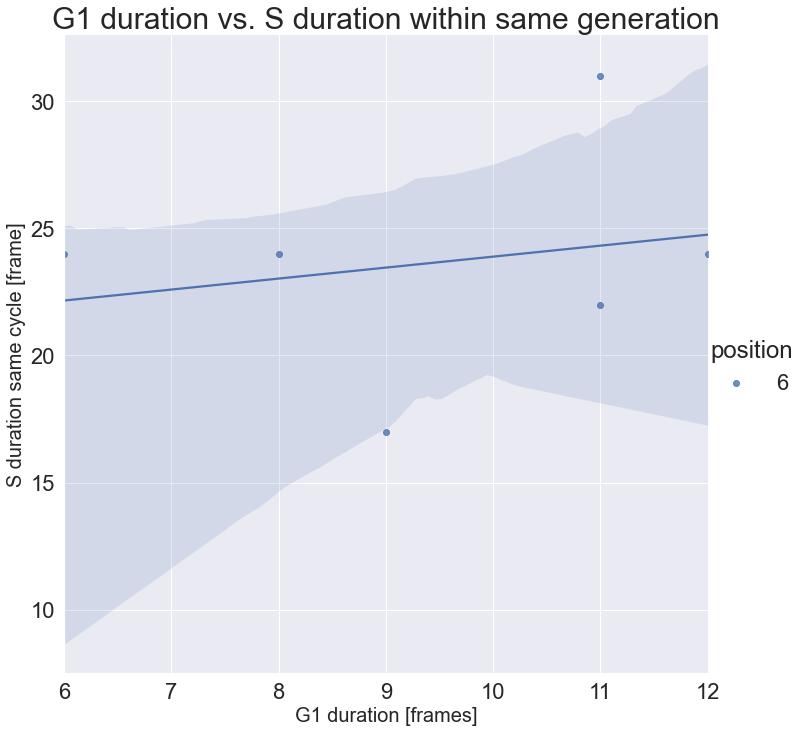

In [150]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data1 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position'], how='inner')
plot_data1 = plot_data1[plot_data1.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(x="phase_length_x", y="phase_length_y", data=plot_data1,
    hue="position", height=10)
ax = plt.gca()
ax.set_ylabel("S duration same cycle [frame]", fontsize=20)
ax.set_xlabel("G1 duration [frames]", fontsize=20)
ax.set_title("G1 duration vs. S duration within same generation", fontsize=30)

## growth in G1 vs. mother+daughter growth in S (1st generation)

Text(0.5, 1.0, 'G1 growth vs. mother+daughter cell S growth')

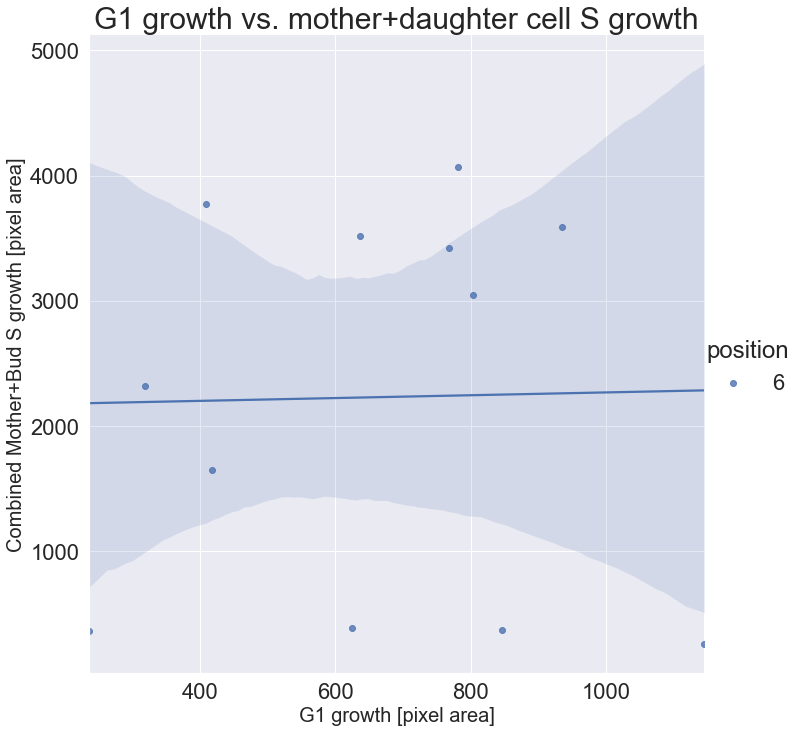

In [152]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.incomplete_cycle==0]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data2 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position'], how='inner')
plot_data2 = plot_data2[plot_data2.generation_num==1]
plot_data2['combined_motherbud_growth'] = plot_data2['growth_in_phase_y'] + plot_data2['daughter_growth_y']

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(x="growth_in_phase_x", y="combined_motherbud_growth", data=plot_data2,
    hue="position", height=10)
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S growth [pixel area]", fontsize=20)
ax.set_xlabel("G1 growth [pixel area]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth", fontsize=30)

## Size at birth vs. G1 growth (1st generation)
- only first generation or all?

Text(0.5, 1.0, 'Size at birth vs G1 duration (1st generation)')

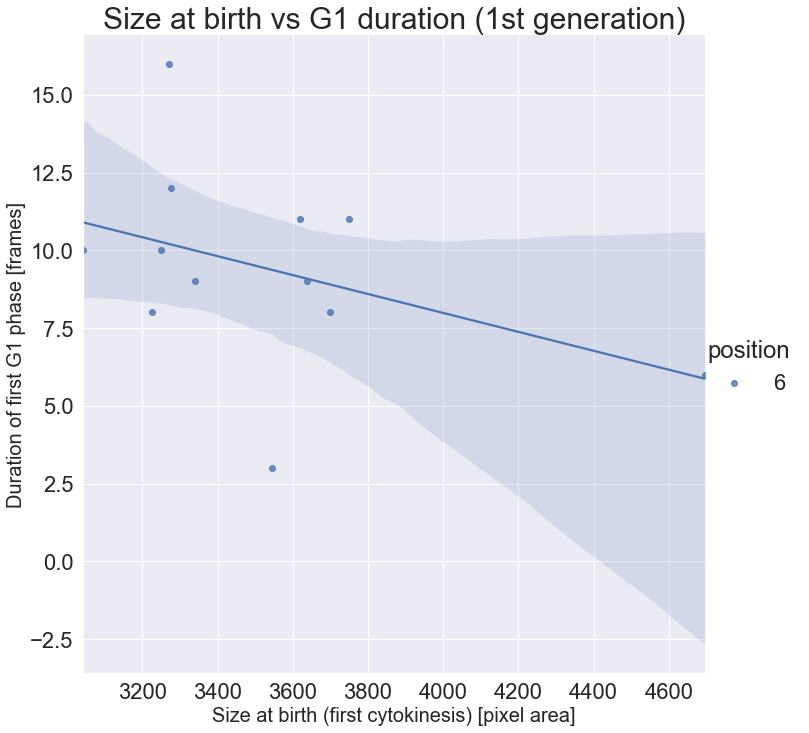

In [153]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data3 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data3 = plot_data3[plot_data3.incomplete_phase==0]
plot_data3 = plot_data3[plot_data3.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(x="area_at_beginning", y="phase_length", data=plot_data3,
    hue="position", height=10)
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Size at birth (first cytokinesis) [pixel area]", fontsize=20)
ax.set_title("Size at birth vs G1 duration (1st generation)", fontsize=30)

## Flurescence Signal over time
### TODO:
- calculate signal strength on cell border (more interesting for Cdc10)
- build groups of positions to compare with each other

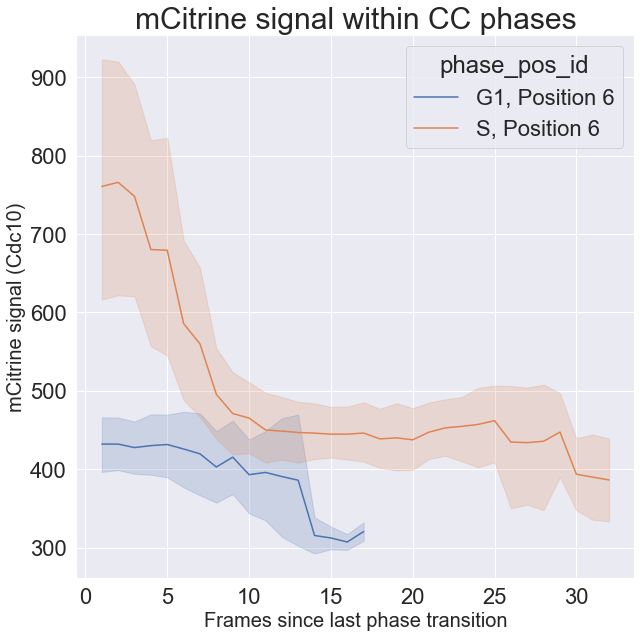

In [155]:
plot_data3 = overall_df.copy()

plot_data3['frames_in_phase'] = plot_data3.sort_values(['frame_i'], ascending=True)\
             .groupby(['position', 'Cell_ID', 'cell_cycle_stage', 'generation_num'])\
             .cumcount() + 1
plot_data3['phase_pos_id'] = plot_data3.apply(lambda x: str(x.loc['cell_cycle_stage'])+', '+'Position '+str(x.loc['position']), axis=1)

f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=plot_data3.sort_values('phase_pos_id'), x="frames_in_phase", y="mCitrine_corrected_mean_signal", 
             hue='phase_pos_id')
ax.set_ylabel("mCitrine signal (Cdc10)", fontsize=20)
ax.set_xlabel("Frames since last phase transition", fontsize=20)
ax.set_title("mCitrine signal within CC phases", fontsize=30)
plt.show()

## boxplot backup

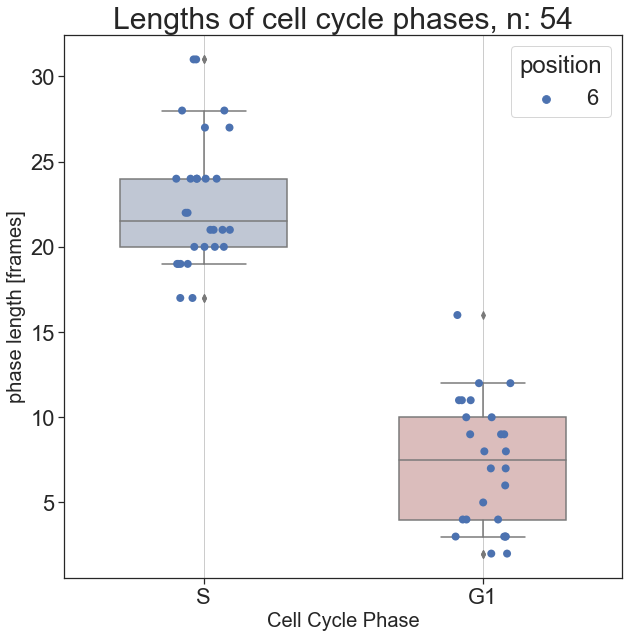

In [156]:
plot_data1 = phase_grouped[~incomplete_phase_indices]
sns.set_theme(style="ticks", font_scale=2)

# Initialize the figure
f, ax = plt.subplots(figsize=(10, 10))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
            whis=[5, 95], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
              size=8, hue="position", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set_ylabel("phase length [frames]", fontsize=20)
ax.set_xlabel("Cell Cycle Phase", fontsize=20)
ax.set_title(f"Lengths of cell cycle phases, n: {plot_data1.shape[0]}", fontsize=30)
#sns.despine(trim=True, left=True)
plt.show()